# locaTE.jl Tutorial: Understanding Cell-Specific Gene Regulatory Networks

## What is locaTE?

**locaTE** (Local Transfer Entropy) is a method that infers **directed gene regulatory networks** from single-cell RNA-seq data by leveraging **dynamical information** like RNA velocity.

### Key Concepts:

1. **Transfer Entropy (TE)**: Measures how much information Gene A provides about the *future* state of Gene B, beyond what Gene B's own past tells us. This captures directional causality.

2. **Local**: Instead of one global network, locaTE computes networks that vary across cell states (e.g., stem cells vs differentiated cells).

3. **Dynamics**: Uses RNA velocity (or other transition information) to understand which cells transition to which states.

### Why is this powerful?
- Standard methods (correlation, mutual information) are **symmetric** and **static**
- locaTE captures **directional** relationships and **context-specific** regulation
- Reveals how gene regulatory networks change during differentiation, development, or disease progression


## Part 1: Data Preprocessing (Python)

### Required Inputs

locaTE needs 4 key matrices:

1. **X**: Gene expression matrix (cells × genes)
2. **X_rep**: Low-dimensional embedding (cells × PCs or UMAP coordinates)
3. **P**: Transition matrix (cells × cells) - probabilities of cell i → cell j
4. **R**: Kernel/similarity matrix (cells × cells)


In [30]:
import anndata as ad
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import ot  # optimal transport library
import os

# Create output directory
DATA_DIR = "locaTE_data/"
os.makedirs(DATA_DIR, exist_ok=True)


### Step 1: Load and Filter Data


In [31]:

# Load your single-cell data and print its info
adata = ad.read_h5ad("_data/DentateGyrus/DentateGyrus_anndata.h5ad")
print(adata)



# Filter and normalize
# This keeps genes detected in at least 20 cells and selects top 2000 variable genes
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

# Run PCA
sc.pp.pca(adata, n_comps=30)

# Build k-nearest neighbor graph to compute the locaTE transition matrix (P) and kernel matrix (R) 
sc.pp.neighbors(adata, n_neighbors=30)


print("\n------NOW-----")
print(adata)


AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'
Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/opt/miniconda3/envs/single-cell/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)



------NOW-----
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'log1p', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'


### Step 2: Get Transition Matrix (P)

The transition matrix is typically computed from **RNA velocity**. If you have velocity data:

Think of `P` as a map of cell state transitions:

```text
         Cell 1  Cell 2  Cell 3  Cell 4
Cell 1   0.1     0.5     0.3     0.1    ← Cell 1 has 50% chance → Cell 2
Cell 2   0.0     0.2     0.6     0.2    ← Cell 2 has 60% chance → Cell 3
Cell 3   0.0     0.0     0.4     0.6    ← Cell 3 has 60% chance → Cell 4
Cell 4   0.0     0.0     0.0     1.0    ← Cell 4 stays at Cell 4 (terminal)
```

locaTE uses the transition matrix to answer:  
> "If Gene A is expressed in cell *i* (current state), does it predict Gene B's expression in cell *j* (future state)?"

This is the **transfer entropy** calculation—measuring directed information flow along the cell state transitions.



In [3]:
# Option A: If you have RNA velocity computed
# scv.tl.velocity(adata)
# scv.tl.velocity_graph(adata)
# P = adata.uns['velocity_graph']  # or similar, depending on your velocity method

# Option B: For this tutorial, we'll use a simple diffusion approximation
# This is a simplified example - real analysis should use proper velocity!
from scipy.sparse import csr_matrix

# Use the neighbor graph as a simple transition matrix
P = adata.obsp['connectivities'].toarray()
# Row-normalize to make it a proper transition matrix
P = P / P.sum(axis=1, keepdims=True)

# Save P matrix
np.save(os.path.join(DATA_DIR, "P.npy"), P)


### Step 3: Compute Kernel Matrix (R)

The kernel matrix captures cell-cell similarities and helps smooth the local TE estimates.


In [32]:
# Construct cell-cell distance matrix from kNN graph
nb = sk.neighbors.NearestNeighbors(n_neighbors=30).fit(adata.obsm["X_pca"])
G_sp = nb.kneighbors_graph(mode="distance")

# Compute shortest path distances between all cells
C = sp.sparse.csgraph.floyd_warshall(G_sp, directed=False)**2

# Calculate neighborhood kernel using optimal transport
# This creates a smooth similarity matrix
n_cells = adata.shape[0]
R = ot.smooth.smooth_ot_dual(
    np.ones(n_cells), 
    np.ones(n_cells), 
    C, 
    2.5 * C.mean()
)

# Save R matrix
np.save(os.path.join(DATA_DIR, "R.npy"), R)


### Step 4: Focus on Transcription Factors (Optional but Recommended)

Since we're interested in regulatory networks, focusing on transcription factors (TFs) makes biological sense.


In [5]:

# run cp _external/locaTE.jl/examples/HSPC/data/Mus_musculus_TF locaTE_data/ (用的是 Mus_musculus_TF 和大脑🧠的不一定是一个吧)
# TF来源： https://github.com/zsteve/locaTE.jl/blob/main/examples/HSPC/data/Mus_musculus_TF 

# OR Download mouse TF list from AnimalTFDB3
# !wget http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF -P {DATA_DIR}

# Or for human:
# !wget http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Homo_sapiens_TF -P {DATA_DIR}

# Load TF list
tf_df = pd.read_csv(os.path.join(DATA_DIR, "Mus_musculus_TF"), sep="\t")

# Mark which genes are TFs
adata.var['is_tf'] = np.isin(
    adata.var.index.str.lower(), 
    tf_df.Symbol.str.lower()
)

print(f"Found {adata.var['is_tf'].sum()} transcription factors in dataset")

# Subset to TFs and select highly variable ones
adata_tf = adata[:, adata.var.is_tf].copy()
sc.pp.log1p(adata_tf)
sc.pp.highly_variable_genes(adata_tf, n_top_genes=100, subset=True)

print(f"Using {adata_tf.shape[1]} highly variable TFs for network inference")


Found 94 transcription factors in dataset
Using 94 highly variable TFs for network inference


### Step 5: Save Prepared Data


In [15]:
import scipy as sp

# Save expression matrix (log-normalized) - convert sparse to dense
if sp.sparse.issparse(adata_tf.X):
    X_array = adata_tf.X.toarray()  # Convert to dense
    print(f"Converted sparse matrix to dense: {X_array.shape}")
else:
    X_array = np.array(adata_tf.X)

# Save as float64
np.save(os.path.join(DATA_DIR, "X.npy"), X_array.astype(np.float64))

# Save PCA coordinates
np.save(os.path.join(DATA_DIR, "X_pca.npy"), adata_tf.obsm["X_pca"])

# Save UMAP for visualization (if available)
if 'X_umap' in adata_tf.obsm:
    np.save(os.path.join(DATA_DIR, "X_umap.npy"), adata_tf.obsm["X_umap"])

# Save the filtered AnnData object for later
adata_tf.write_h5ad(os.path.join(DATA_DIR, "adata_processed.h5ad"))

print("Data preparation complete!")
print(f"Shape: {adata_tf.shape[0]} cells × {adata_tf.shape[1]} genes")

# Verify saved correctly
X_check = np.load(os.path.join(DATA_DIR, "X.npy"))
print(f"✓ X.npy verified: shape={X_check.shape}, dtype={X_check.dtype}")

Converted sparse matrix to dense: (2930, 94)
Data preparation complete!
Shape: 2930 cells × 94 genes
✓ X.npy verified: shape=(2930, 94), dtype=float64


In [17]:
adata_tf.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 46618 stored elements and shape (2930, 94)>

In [18]:
import numpy as np
import os

DATA_DIR = "locaTE_data/"

files = ["X.npy", "X_pca.npy", "P.npy", "R.npy"]

for fname in files:
    try:
        arr = np.load(os.path.join(DATA_DIR, fname), allow_pickle=True)  # Add allow_pickle
        print(f"{fname}: shape={arr.shape}, dtype={arr.dtype}")
    except Exception as e:
        print(f"{fname}: ERROR - {e}")

X.npy: shape=(2930, 94), dtype=float64
X_pca.npy: shape=(2930, 30), dtype=float32
P.npy: shape=(2930, 2930), dtype=float32
R.npy: shape=(2930, 2930), dtype=float64


## Part 2: Running locaTE (Julia)

### Understanding the Command

The main locaTE algorithm is run from Julia using a command-line interface:

```bash
julia locaTE_cmd.jl \
  --lambda1 10.0 \        # Regularization for sparsity
  --lambda2 0.001 \       # Regularization for smoothness
  --k_lap 25 \            # Number of neighbors for Laplacian
  --tau 1 \               # Power for transition matrix
  --cutoff 0.3 \          # Threshold for edge weights
  --gpu \                 # Use GPU acceleration (optional)
  --outdir locaTE_output/ \
  X.npy X_pca.npy P.npy R.npy
```

### Key Parameters:

- **lambda1**: Higher values → sparser networks (fewer edges)
- **lambda2**: Controls smoothness across similar cells
- **k_lap**: Number of neighbors for constructing the graph Laplacian
- **tau**: Power to raise the transition matrix P (higher = longer time scales)
- **cutoff**: Post-processing threshold to remove weak edges


In [ ]:
# # Run from Python using subprocess (or in terminal see below) 
# import subprocess

# OUT_DIR = "locaTE_output/"
# os.makedirs(OUT_DIR, exist_ok=True)

# # Path to locaTE_cmd.jl (adjust to your installation)
# LOCATE_PATH = "_external/locaTE.jl/src/locaTE_cmd.jl"
# PROJECT_PATH = "_external/locaTE.jl"  # Add this line

# cmd = [
#     "julia",
#     f"--project={PROJECT_PATH}",  # Add this flag
#     LOCATE_PATH,
#     "--lambda1", "10.0",
#     "--lambda2", "0.001",
#     "--k_lap", "25",
#     "--outdir", OUT_DIR,
#     os.path.join(DATA_DIR, "X.npy"),
#     os.path.join(DATA_DIR, "X_pca.npy"),
#     os.path.join(DATA_DIR, "P.npy"),
#     os.path.join(DATA_DIR, "R.npy")
# ]

# print("Running locaTE... This may take several minutes.")
# subprocess.run(cmd, check=True)



Terminal Command: （大概1小时）

```
sysctl -n hw.ncpu  # macOS, To find your CPU core count:

cd /Users/dannyhuang/Developer/tutorial-cell2fate

# Run with 8 threads (adjust based on your CPU cores)
JULIA_NUM_THREADS=8 julia --project=_external/locaTE.jl \
  _external/locaTE.jl/src/locaTE_cmd.jl \
  --lambda1 10.0 \
  --lambda2 0.001 \
  --k_lap 25 \
  --outdir locaTE_output/ \
  locaTE_data/X.npy \
  locaTE_data/X_pca.npy \
  locaTE_data/P.npy \
  locaTE_data/R.npy

```

### What locaTE Computes

The algorithm outputs:

1. **TE.npy**: Raw transfer entropy matrix (genes × genes × cells)
2. **G_cdf.npy**: Denoised network after applying regularization
3. **L.npy**: Graph Laplacian used for smoothing

Each cell gets its own gene regulatory network!


## Part 3: Analyzing Results (Python)

### Load locaTE Output


In [34]:

# Load the processed data and locaTE resultsOUT_DIR = "locaTE_output/"
OUT_DIR = "locaTE_output/"
adata = ad.read_h5ad(os.path.join(DATA_DIR, "adata_processed.h5ad"))

# Load locaTE outputs
G = np.load(os.path.join(OUT_DIR, "G_cdf.npy"))
L = np.load(os.path.join(OUT_DIR, "L.npy"))

# Reshape G: it's a (cells × genes² ) matrix
# Each row is a flattened (genes × genes) adjacency matrix for one cell
n_genes = adata.shape[1]
n_cells = adata.shape[0]

# Fix Julia column-major to Python row-major orientation
G_reshaped = np.swapaxes(
    G.reshape(-1, n_genes, n_genes), 1, 2
).reshape(-1, n_genes**2)

adata.uns["G"] = G_reshaped
adata.uns["L"] = L

print(f"Loaded cell-specific networks: {n_cells} cells × {n_genes}² interactions")


Loaded cell-specific networks: 2930 cells × 94² interactions


### Visualize Average Network


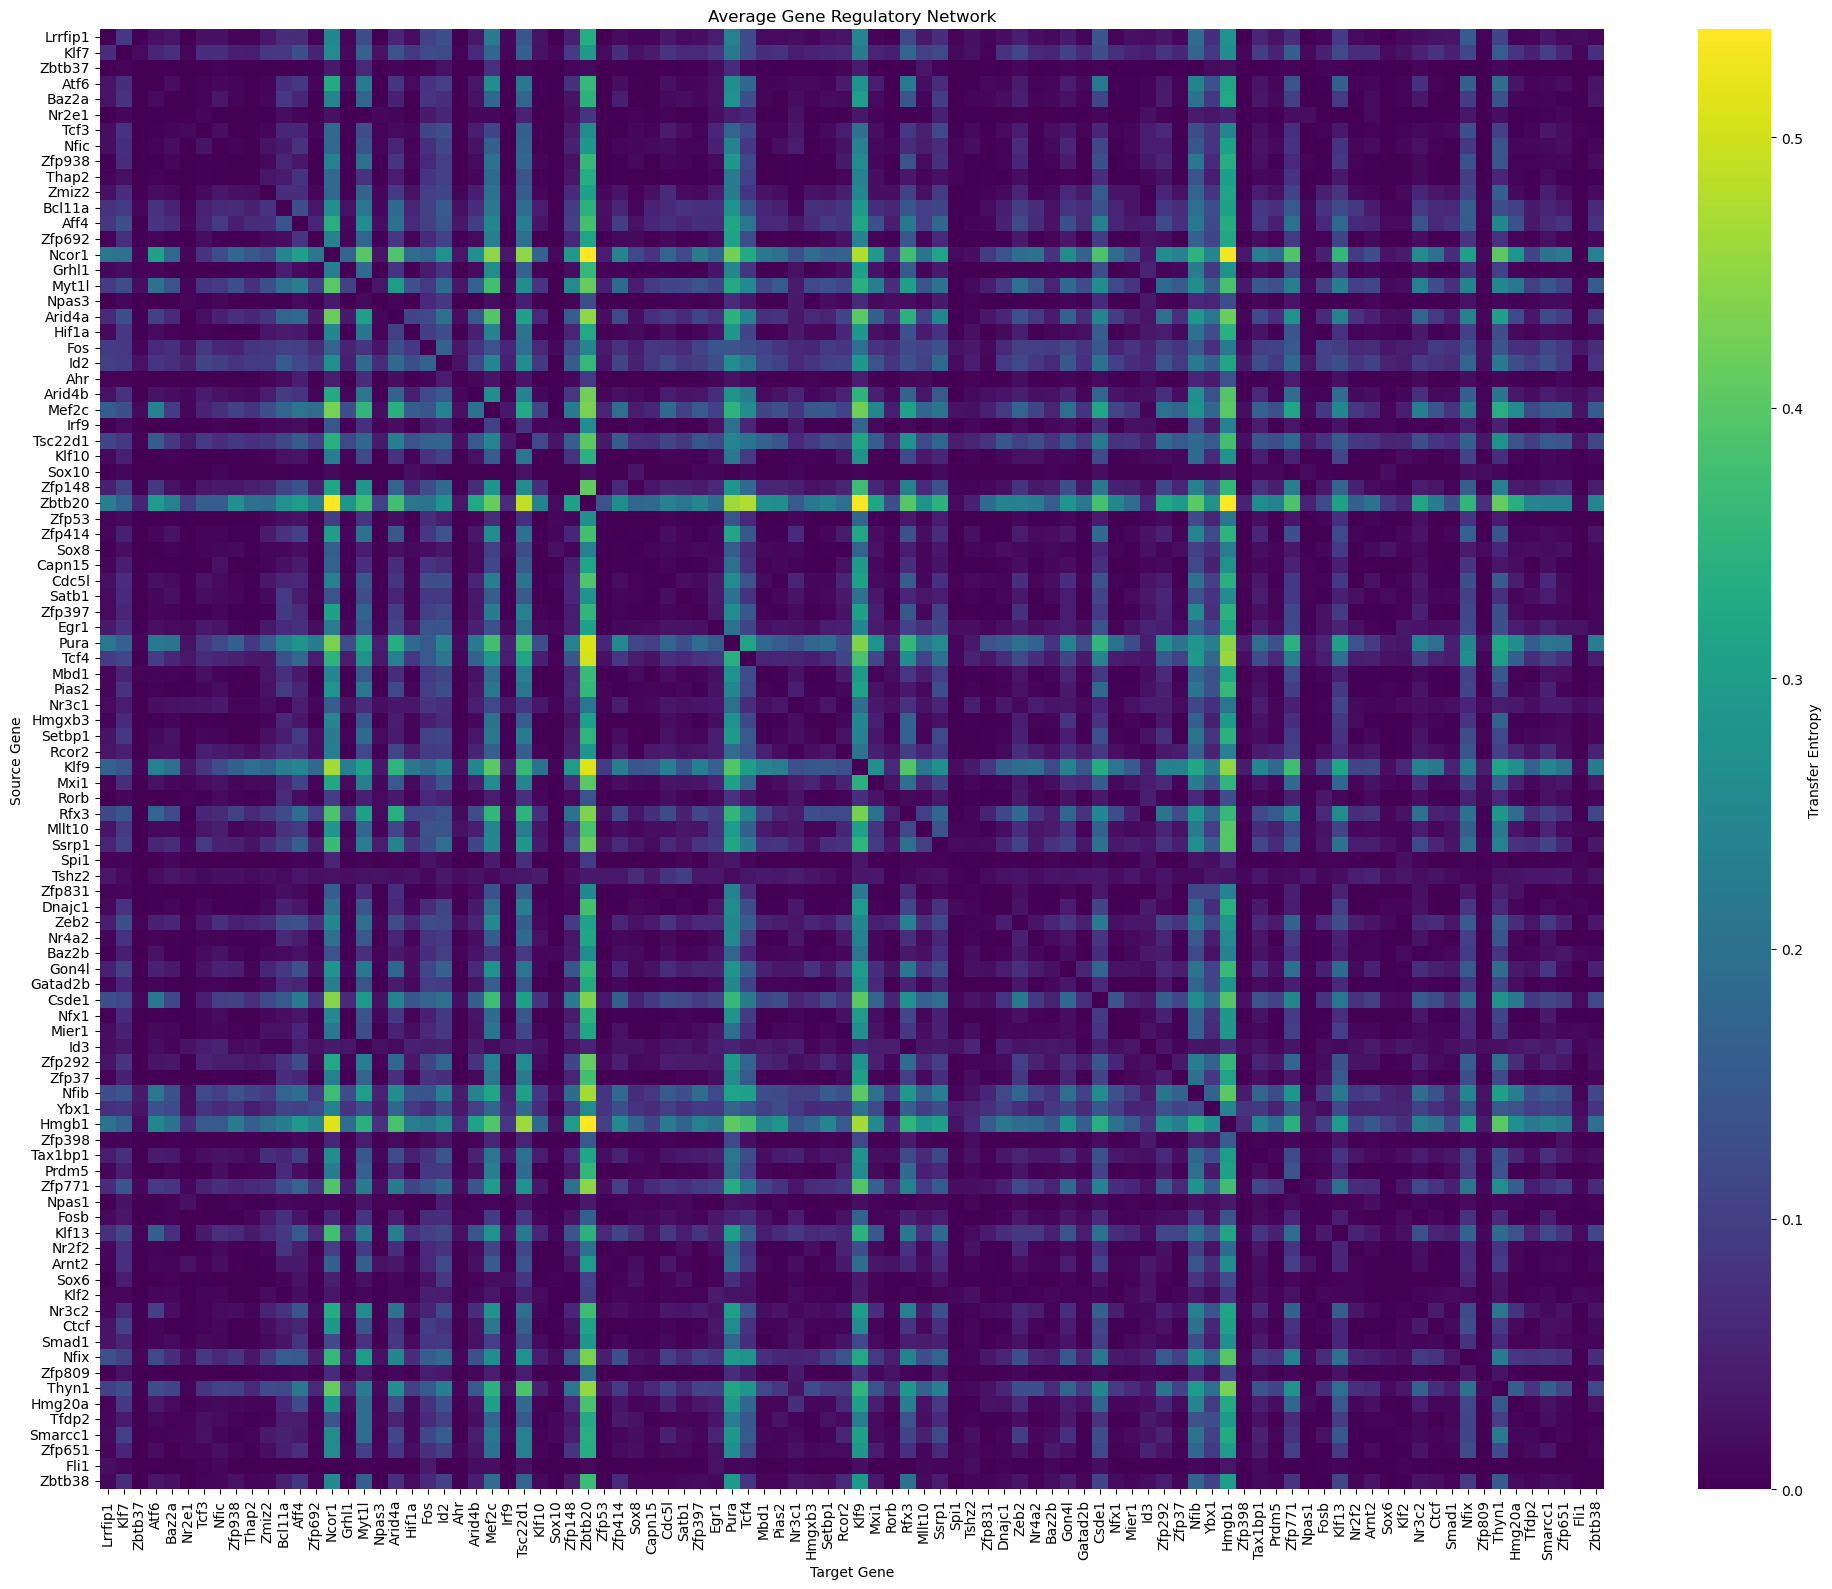

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute average network across all cells
avg_network = adata.uns["G"].mean(axis=0).reshape(n_genes, n_genes)

# Visualize as heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    avg_network,
    cmap="viridis",
    xticklabels=adata.var.index,
    yticklabels=adata.var.index,
    cbar_kws={'label': 'Transfer Entropy'}
)
plt.title("Average Gene Regulatory Network")
plt.xlabel("Target Gene")
plt.ylabel("Source Gene")
plt.tight_layout()
plt.show()


### Compare Networks Across Cell Types


In [21]:
# If you have cell type annotations
if 'cell_type' in adata.obs.columns:
    # Pick two cell types to compare
    cell_types = adata.obs['cell_type'].unique()[:2]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    for i, ct in enumerate(cell_types):
        # Get networks for cells of this type
        mask = adata.obs['cell_type'] == ct
        ct_network = adata.uns["G"][mask, :].mean(axis=0).reshape(n_genes, n_genes)
        
        sns.heatmap(
            ct_network,
            ax=axes[i],
            cmap="viridis",
            xticklabels=adata.var.index,
            yticklabels=adata.var.index
        )
        axes[i].set_title(f"{ct} Network")
    
    plt.tight_layout()
    plt.show()


### Find Top Regulatory Interactions


In [22]:
# Find strongest regulatory links in the average network
avg_network = adata.uns["G"].mean(axis=0).reshape(n_genes, n_genes)

# Get top 20 interactions
flat_idx = np.argsort(avg_network.flatten())[-20:][::-1]
row_idx, col_idx = np.unravel_index(flat_idx, avg_network.shape)

print("\nTop 20 Regulatory Interactions:")
print("Source Gene → Target Gene : Strength")
print("-" * 50)

for i in range(len(row_idx)):
    source = adata.var.index[row_idx[i]]
    target = adata.var.index[col_idx[i]]
    strength = avg_network[row_idx[i], col_idx[i]]
    print(f"{source:>10s} → {target:<10s} : {strength:.4f}")



Top 20 Regulatory Interactions:
Source Gene → Target Gene : Strength
--------------------------------------------------
     Hmgb1 → Zbtb20     : 0.5400
     Ncor1 → Zbtb20     : 0.5396
    Zbtb20 → Ncor1      : 0.5378
    Zbtb20 → Hmgb1      : 0.5360
    Zbtb20 → Klf9       : 0.5354
     Ncor1 → Hmgb1      : 0.5310
     Hmgb1 → Ncor1      : 0.5141
      Klf9 → Zbtb20     : 0.5107
      Pura → Zbtb20     : 0.5086
      Tcf4 → Zbtb20     : 0.5023
    Zbtb20 → Tsc22d1    : 0.4905
     Ncor1 → Klf9       : 0.4767
    Zbtb20 → Tcf4       : 0.4755
     Hmgb1 → Klf9       : 0.4669
      Klf9 → Ncor1      : 0.4665
      Nfib → Zbtb20     : 0.4660
    Zbtb20 → Pura       : 0.4601
     Hmgb1 → Tsc22d1    : 0.4580
      Tcf4 → Hmgb1      : 0.4573
     Thyn1 → Zbtb20     : 0.4529


## Part 4: Advanced Analysis - NMF Decomposition (Optional)

For large networks, you can decompose them into **regulatory modules** using Non-negative Matrix Factorization (NMF).

This is done in Julia using locaTE's `fitnmf` function. The result gives:
- **U matrix**: Module activities across cells (cells × modules)
- **V matrix**: Module network structure (modules × genes²)

See the HSPC example notebooks in `_external/locaTE.jl/examples/HSPC/` for detailed implementation.


## Summary

### The locaTE Workflow:

1. **Prepare Data** (Python)
   - Load single-cell data
   - Compute transition matrix P (from velocity)
   - Compute kernel matrix R (from cell similarities)
   - Extract genes of interest (e.g., TFs)

2. **Run locaTE** (Julia)
   - Estimates transfer entropy for each cell
   - Applies regularization and denoising
   - Outputs cell-specific regulatory networks

3. **Analyze Results** (Python)
   - Visualize networks
   - Compare across cell types/states
   - Identify key regulatory interactions
   - (Optional) Decompose into modules with NMF

### Key Advantages:
- **Directional**: Captures regulator → target relationships
- **Dynamic**: Uses velocity information
- **Context-specific**: Different networks for different cell states
- **Scalable**: GPU acceleration available

### Further Resources:
- [locaTE preprint](https://www.biorxiv.org/content/10.1101/2023.01.08.523176v1)
- [Documentation](https://zsteve.phatcode.net/locatedocs/)
- [Paper code repository](https://github.com/zsteve/locaTE-paper)
